In [1]:
import pandas as pd
import datetime as dt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Define the start and end dates
start = dt.datetime(2021, 6, 1)
end = dt.datetime(2022, 1, 5)
symbol = 'AXISBANK.NS'

# Fetch stock data
stk_data = yf.download(symbol, start=start, end=end)
stk_data = stk_data[['Open', 'High', 'Low', 'Close']]

# Normalize data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(stk_data[['Close']])
data_normalized = pd.DataFrame(data_normalized, columns=["Close"])


[*********************100%%**********************]  1 of 1 completed


In [2]:
test_obs = 29
train = data_normalized[:-test_obs]
test = data_normalized[-test_obs:]

In [4]:
import warnings
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import pandas as pd

# Suppress warnings
warnings.filterwarnings("ignore")

# Assuming 'train' and 'test' are defined earlier from your dataset

# Fit the Simple Exponential Smoothing model
best_aic = float("inf")
best_alpha = None
best_model = None

# Iterate over a range of alpha values to find the best one
for alpha in [0.8]:
    try:
        # Fit the Simple Exponential Smoothing model
        model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        print('Smoothing Level: ', alpha)
        
        # Calculate AIC (Akaike Information Criterion)
        aic = model.aic
        
        if aic < best_aic:
            best_aic = aic
            best_alpha = alpha
            best_model = model
            
    except Exception as e:
        print(f"Error fitting model for alpha={alpha}: {e}")
        continue

# Forecast for the test set period
forecast = best_model.forecast(steps=len(test))
forecast_df = pd.DataFrame(forecast, columns=["Close"])  # Adjust column name if needed

# Calculate performance metrics
rmse = mean_squared_error(test, forecast_df, squared=False)
mape = mean_absolute_percentage_error(test, forecast_df)

# Display performance metrics
performance = {
    "Model": ["SimpleExponentialSmoothing"],
    "RMSE": [rmse],
    "MAPE": [mape],
    "Alpha": [best_alpha],  # Best smoothing level
    "Test": [len(test)]
}
perf = pd.DataFrame(performance)
print(perf)


Smoothing Level:  0.8
                        Model      RMSE          MAPE  Alpha  Test
0  SimpleExponentialSmoothing  0.088833  2.750043e+13    0.8    29


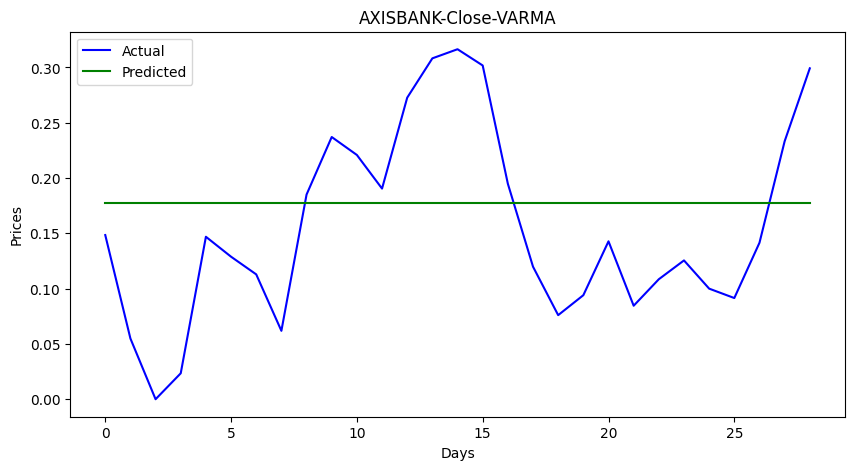

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(test["Close"].values, color='blue', label="Actual")
plt.plot(forecast_df["Close"].values, color='green', label="Predicted")
plt.title("AXISBANK-Close-VARMA")
plt.xlabel("Days")
plt.ylabel("Prices")
plt.legend()
plt.show()

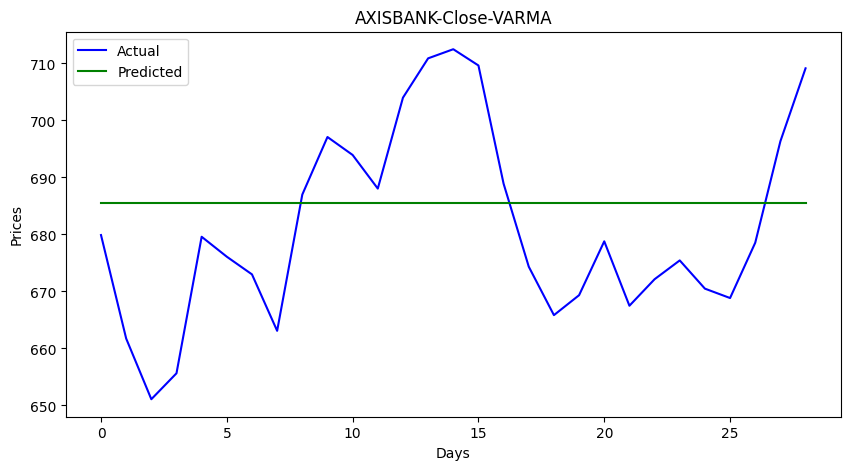

In [6]:
actual_stock_price_test_ori = scaler.inverse_transform(test)
actual_stock_price_test_ori_df = pd.DataFrame(actual_stock_price_test_ori, columns=[ "Close"])

predicted_stock_price_test_ori = scaler.inverse_transform(forecast_df)
predicted_stock_price_test_ori_df = pd.DataFrame(predicted_stock_price_test_ori, columns=[ "Close"])

# Plotting actual vs. predicted values on original scale
plt.figure(figsize=(10, 5))
plt.plot(actual_stock_price_test_ori_df["Close"], color='blue', label="Actual")
plt.plot(predicted_stock_price_test_ori_df["Close"], color='green', label="Predicted")
plt.title("AXISBANK-Close-VARMA")
plt.xlabel("Days")
plt.ylabel("Prices")
plt.legend()
plt.show()

In [7]:
predicted_stock_price_test_ori_df

,Close
0,685.454141
1,685.454141
2,685.454141
3,685.454141
4,685.454141
5,685.454141
6,685.454141
7,685.454141
8,685.454141
9,685.454141


RMSE-Testset (Original): 17.233558103241766
MAPE-Testset (Original): 0.02202344517775392


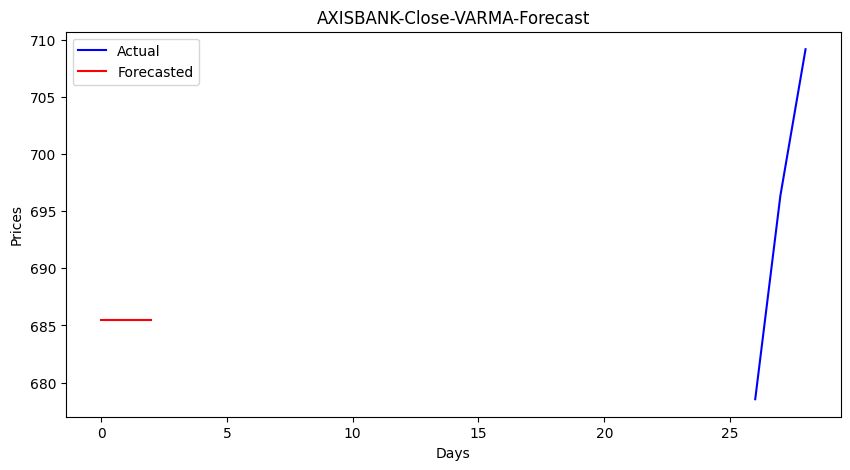

In [10]:
rmse_ori = mean_squared_error(actual_stock_price_test_ori_df["Close"], predicted_stock_price_test_ori_df["Close"], squared=False)
mape_ori = mean_absolute_percentage_error(actual_stock_price_test_ori_df["Close"], predicted_stock_price_test_ori_df["Close"])
print("RMSE-Testset (Original):", rmse_ori)
print("MAPE-Testset (Original):", mape_ori)

# Forecast future prices
forecast_steps = 3  # Adjust as needed
forecast_future = best_model.forecast(steps=forecast_steps)
forecast_future_df = pd.DataFrame(forecast_future, columns=[ "Close"])

# Inverse transform future forecast to original scale
forecast_future_prices = scaler.inverse_transform(forecast_future_df)
forecast_future_prices_df = pd.DataFrame(forecast_future_prices, columns=[ "Close"])

# Save forecasted prices
forecast_future_prices_df.to_csv("CloseVARMAForecast.csv", index=False)

# Plotting actual vs. forecasted future prices
plt.figure(figsize=(10, 5))
plt.plot(actual_stock_price_test_ori_df["Close"].iloc[-forecast_steps:], color='blue', label="Actual")
plt.plot(forecast_future_prices_df["Close"], color='red', label="Forecasted")
plt.title("AXISBANK-Close-VARMA-Forecast")
plt.xlabel("Days")
plt.ylabel("Prices")
plt.legend()
plt.show()